In [1]:
# import opencv
import cv2
# import mediapipe for pose estimation libraries and mediapipe solutions
import mediapipe as mp 
# import numpy for trigonometry
import numpy as np # import numpy
# time library needed for delay
import time
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pycaret.classification import *

#pd.set_option('display.max_columns', 1000)
#pd.set_option('display.max_rows', 1000)

# set up mediapipe
# import drawing_utils for drawing utility
mp_drawing = mp.solutions.drawing_utils 
# import pose for estimation models
mp_pose = mp.solutions.pose

In [2]:
# loading saved model
saved_final_blended = load_model('Final Prediction Model 2 Sep 2021')

Transformation Pipeline and Model Successfully Loaded


In [3]:
# function for predicting if ball will curve
def will_curve(dat):
    #result = {"curveornot":[], "accuracy":[]}
    result = []
    pred = predict_model(saved_final_blended, data=dat)
    #result['curveornot'].append(pred['Label'])
    #result['accuracy'].append(pred['Score'])
    frame = pd.DataFrame(pred)
    result.append(frame['Label'].values[0])
    result.append(frame['Score'].values[0])
    
    
    #return result
    return result

In [4]:
# function for filling up df for model fitting
def fill_up(origDF):
    col = list(origDF.columns)
    for i in col:
        origDF[i] = pd.to_numeric(origDF[i], errors='coerce')
    origDF['rightankle leftankle'] = origDF['rightankle'] * origDF['leftankle']
    origDF['rightankle rightknee'] = origDF['rightankle'] * origDF['rightknee']
    origDF['rightankle leftknee'] = origDF['rightankle'] * origDF['leftknee']
    origDF['rightankle righthip'] = origDF['rightankle'] * origDF['righthip']
    origDF['rightankle lefthip'] = origDF['rightankle'] * origDF['lefthip']
    origDF['rightankle rightshoulder'] = origDF['rightankle'] * origDF['rightshoulder']
    origDF['rightankle leftshoulder'] = origDF['rightankle'] * origDF['leftshoulder']
    origDF['leftankle rightknee'] = origDF['leftankle'] * origDF['rightknee']
    origDF['leftankle leftknee'] = origDF['leftankle'] * origDF['leftknee']
    origDF['leftankle righthip'] = origDF['leftankle'] * origDF['righthip']
    origDF['leftankle lefthip'] = origDF['leftankle'] * origDF['lefthip']
    origDF['leftankle rightshoulder'] = origDF['leftankle'] * origDF['rightshoulder']
    origDF['leftankle leftshoulder'] = origDF['leftankle'] * origDF['leftshoulder']
    origDF['rightknee leftknee'] = origDF['rightknee'] * origDF['leftknee']
    origDF['rightknee righthip'] = origDF['rightknee'] * origDF['righthip']
    origDF['rightknee lefthip'] = origDF['rightknee'] * origDF['lefthip']
    origDF['rightknee rightshoulder'] = origDF['rightknee'] * origDF['rightshoulder']
    origDF['rightknee leftshoulder'] = origDF['rightknee'] * origDF['leftshoulder']
    origDF['leftknee righthip'] = origDF['leftknee'] * origDF['righthip']
    origDF['leftknee lefthip'] = origDF['leftknee'] * origDF['lefthip']
    origDF['leftknee rightshoulder'] = origDF['leftknee'] * origDF['rightshoulder']
    origDF['leftknee leftshoulder'] = origDF['leftknee'] * origDF['leftshoulder']
    origDF['righthip lefthip'] = origDF['righthip'] * origDF['lefthip']
    origDF['righthip rightshoulder'] = origDF['righthip'] * origDF['rightshoulder']
    origDF['righthip leftshoulder'] = origDF['righthip'] * origDF['leftshoulder']
    origDF['lefthip rightshoulder'] = origDF['lefthip'] * origDF['rightshoulder']
    origDF['lefthip leftshoulder'] = origDF['lefthip'] * origDF['leftshoulder']
    origDF['rightshoulder leftshoulder'] = origDF['rightshoulder'] * origDF['leftshoulder']
    return origDF


In [5]:
# function for calculating angle
def calculate_angle(a,b,c):
    a = np.array(a) # First point (hip)
    b = np.array(b) # Mid point (knee)
    c = np.array(c) # End point (ankle)
    
    # Y.ankle - Y.knee , X.ankle - X.knee  -  Y.knee - Y.hip , X.knee - X. hip
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    #converting radians to degrees
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0: #max angle is 180
        angle = 360-angle
        
    return angle

### Final Visualization

In [6]:
#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture('../assets/31augtest.mp4')


###########################################################################################
# Global ariables

# counter variable for previous end of line for drawing flight path
xp, yp = 0, 0

# counter variable for checking end of flight path for saving flight path image
final_y = 1000

# counter variable for checking kick before touching ball
kick_counter = 0
leg_stage = None

# global variables for speed
speed = 0
final_speed_list = [0]
max_speed = 0

# global variable for angles
angle_r_knee = 0
angle_l_knee = 0
angle_r_hip = 0
angle_l_hip = 0
angle_r_ankle = 0
angle_l_ankle = 0
angle_r_shoulder = 0
angle_l_shoulder = 0

# global variable for ret
# ret is a variable from openCV to check if video is at last frame
# is ret = False, there are no more frames left in the video and program should cut

ret = True

###########################################################################################
# list for storing speed
speed_list = []

prediction = [None]

###########################################################################################
# Object Detection
object_detector = cv2.createBackgroundSubtractorMOG2(history = 100, varThreshold = 20)

###########################################################################################
# Image Canvas
imgCanvas = np.zeros((1080, 1920, 3), np.uint8)

###########################################################################################
# create blank dictionary for storing angle values
#anglesDict = {"rightankle":[], "leftankle":[], "righthip":[], "lefthip":[], "rightknee":[], "leftknee":[],
#             "rightshoulder":[],"leftshoulder":[]}

anglesDict_freeze = {"rightankle":[], "leftankle":[], "righthip":[], "lefthip":[], "rightknee":[], "leftknee":[],
             "rightshoulder":[],"leftshoulder":[]}



###########################################################################################
## Setup mediapipe instance
with mp_pose.Pose(smooth_landmarks = True, min_detection_confidence=0.6, min_tracking_confidence=0.6) as pose:
    
    while True:
        
        ret, frame = cap.read()

        if ret == False:
            cap.release()
            cv2.destroyAllWindows()
            break
        
        #print('ret', ret)
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        
        #region of interest -- range of height, range of length in pixel.
        # Davinci output = 1080 by 1920
        roi = image[0:1030, 1200: 1500]
        
        # Extract landmarks
        
        ###########################################################################################
        # RIGHT KNEE ANGLE
        ###########################################################################################
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            r_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,
                     landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
            r_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,
                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            r_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,
                       landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
            
            # Calculate angle
            angle_r_knee = "{:.2f}".format(calculate_angle(r_hip, r_knee, r_ankle))
            
            # Visualize angle
            cv2.putText(image, str(angle_r_knee), 
                           tuple(np.multiply(r_knee, [1920, 1080]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA
                                )
                       
        except:
            pass
        
        ###########################################################################################
        # LEFT KNEE ANGLE
        ###########################################################################################
        
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            l_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,
                     landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            l_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,
                      landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            l_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,
                       landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
            
            # Calculate angle
            angle_l_knee = "{:.2f}".format(calculate_angle(l_hip, l_knee, l_ankle))
            
            # Visualize angle
            cv2.putText(image, str(angle_l_knee), 
                           tuple(np.multiply(l_knee, [1920, 1080]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA
                                )
                       
        except:
            pass

        ###########################################################################################
        # RIGHT HIP ANGLE
        ###########################################################################################
        
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            r_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,
                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
            r_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,
                     landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
            r_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,
                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            
            # Calculate angle
            angle_r_hip = "{:.2f}".format(calculate_angle(r_shoulder, r_hip, r_knee))
            
            # Visualize angle
            cv2.putText(image, str(angle_r_hip), 
                           tuple(np.multiply(r_hip, [1920, 1080]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA
                                )
                       
        except:
            pass

        ###########################################################################################
        # LEFT HIP ANGLE
        ###########################################################################################
        
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            l_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            l_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,
                     landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            l_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,
                      landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            
            # Calculate angle
            angle_l_hip = "{:.2f}".format(calculate_angle(l_shoulder, l_hip, l_knee))
            
            # Visualize angle
            cv2.putText(image, str(angle_l_hip), 
                           tuple(np.multiply(l_hip, [1920, 1080]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA
                                )
                       
        except:
            pass
        
        ###########################################################################################
        # LEFT ANKLE ANGLE
        ###########################################################################################
        
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            l_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,
                      landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            l_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,
                       landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
            l_foot_i = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value].y]
            
            # Calculate angle
            angle_l_ankle = "{:.2f}".format(calculate_angle(l_knee, l_ankle, l_foot_i))
            
            # Visualize angle
            cv2.putText(image, str(angle_l_ankle), 
                           tuple(np.multiply(l_ankle, [1920, 1080]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA
                                )
                       
        except:
            pass
        
        ###########################################################################################
        # RIGHT ANKLE ANGLE
        ###########################################################################################
        
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            r_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,
                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            r_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,
                       landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
            r_foot_i = [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].x,
                        landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].y]
            
            # Calculate angle
            angle_r_ankle = "{:.2f}".format(calculate_angle(r_knee, r_ankle, r_foot_i))
            
            # Visualize angle
            cv2.putText(image, str(angle_r_ankle), 
                           tuple(np.multiply(r_ankle, [1920, 1080]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA
                                )
                       
        except:
            pass
        
        ###########################################################################################
        # RIGHT SHOULDER ANGLE
        ###########################################################################################

        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            r_hip_s = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,
                      landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
            r_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,
                       landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
            r_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,
                        landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
            
            # Calculate angle
            angle_r_shoulder = "{:.2f}".format(calculate_angle(r_hip, r_shoulder, r_elbow))
            
            # Visualize angle
            cv2.putText(image, str(angle_r_shoulder), 
                           tuple(np.multiply(r_shoulder, [1920, 1080]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA
                                )
                       
        except:
            pass        
        
        
        
        ###########################################################################################
        # LEFT SHOULDER ANGLE
        ###########################################################################################
        
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            l_hip_s = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,
                      landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            l_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                       landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            l_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            
            # Calculate angle
            angle_l_shoulder = "{:.2f}".format(calculate_angle(l_hip_s, l_shoulder, l_elbow))
            
            # Visualize angle
            cv2.putText(image, str(angle_l_shoulder), 
                           tuple(np.multiply(l_shoulder, [1920, 1080]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA
                                )
                       
        except:
            pass        
 
        
        
        ###########################################################################################
        # Convert angle to int
        
        counter_angle = float(angle_r_knee)
        ###########################################################################################
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
      
        ###########################################################################################
        # masking for object detector
        mask = object_detector.apply(roi)
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            
            # Calculate area to remove small elements in mask
            area = cv2.contourArea(cnt)
            #print(cnt)
            # area of soccerball
            if 130 > area > 110:
                #cv2.drawContours(roi, [cnt], -1, (0,255,0), 2)
                x, y, w, h = cv2.boundingRect(cnt)
                cv2.rectangle(roi, (x,y), (x + w, y + h), (0, 255, 0), 3)
                #print(x,y)
                
        ##########################################################################################
        # drawing red circle to track
        #cv2.line(image, (xp, yp), (x,y), (0, 0, 255),50)
        # need to add ROI start coordinates to x and y position
        # change number to adjust to overlay over soccer ball        
                x = 1207 + x
                y = 8 + y
                cv2.circle(image, (x, y), 10, (0, 0, 255),3)
                
                if xp == 0 and yp ==0:
                    xp, yp = x, y
                    #print(x,y)
                    #print(xp,yp)
                    
        ##########################################################################################            
        # drawing tracking line
        
                if x - xp > 10:
                    print("Track out of bounds")
                else:
                
                    cv2.line(image, (xp,yp), (x,y), (0, 0, 255),3 )
                    cv2.line(imgCanvas, (xp,yp), (x,y), (0, 0, 255),3 )
                    #print('x1',x,'y1',y)
                    #print('xp before',xp,'yp before',yp)
                    
                    # speed calculation
                    # 10 pixels = 20cm
                    # 1 pixel = 2cm
                    # the video is taken at 120fps, it will be 4x slower than a normal 30fps video
                    # thus 1 pixel = 2 x 4 = 8cm
                    
                    speed_calc = ((yp - y) * 8)/10
                    speed = speed_calc
                    speed_list.append(speed)
                    final_speed_list = [x for x in speed_list if x < np.mean(speed_list) + 3*np.std(speed_list)]
                    max_speed = max(final_speed_list, default=0)
                    
                    xp, yp = x, y
                    final_y = y
                    #print(x,y)
                    #print(xp,yp)
        ##########################################################################################
        # code needed for drawing directly on opencv main frame
        
        
        imgGray = cv2.cvtColor(imgCanvas,cv2.COLOR_BGR2GRAY)
        _, imgInv = cv2.threshold(imgGray, 50, 255, cv2.THRESH_BINARY_INV)
        imgInv = cv2.cvtColor(imgInv, cv2.COLOR_GRAY2BGR)
        image = cv2.bitwise_and(image, imgInv)
        image = cv2.bitwise_or(image, imgCanvas)

        
        ##########################################################################################
        # Draw boxes
        
        # for right hip
        cv2.rectangle(image, (0,0), (150,73), (245,117,16), -1)
        
        # for left hip
        cv2.rectangle(image, (151,0), (301,73), (245,117,16), -1)
        
        # for right knee
        cv2.rectangle(image, (302,0), (452,73), (245,117,16), -1)
        
        # for left knee
        cv2.rectangle(image, (453,0), (603,73), (245,117,16), -1)
        
        # for right ankle
        cv2.rectangle(image, (603,0), (754,73), (245,117,16), -1)
        
        # for left ankle
        cv2.rectangle(image, (755,0), (905,73), (245,117,16), -1)
        
        # for Right shoulder
        cv2.rectangle(image, (906,0), (1090,73), (245,117,16), -1)
        
        # for Left shoulder
        cv2.rectangle(image, (0,74), (205,140), (245,117,16), -1)
        
        # for velocity
        cv2.rectangle(image, (206,74), (411,140), (245,117,16), -1)
        
        # for max speed
        cv2.rectangle(image, (412,74), (635,140), (245,117,16), -1)
        
        # for curl prediction
        cv2.rectangle(image, (0,141), (205,210), (245,117,16), -1)


        
        ##########################################################################################
        # Printing readings on screen
        cv2.putText(image, 'Right Hip Angle', 
                    (15,15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing Right Hip Angle on screen
        cv2.putText(image, str(angle_r_hip), 
                    (10,60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        # Printing Left Hip Angle label on screen
        cv2.putText(image, 'Left Hip Angle', 
                    (166,15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing Left Hip Angle on screen
        cv2.putText(image, str(angle_l_hip), 
                    (161,60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        # Printing Right Knee Angle label on screen
        cv2.putText(image, 'Right Knee Angle', 
                    (317,15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing Right Knee Angle on screen
        cv2.putText(image, str(angle_r_knee), 
                    (312,60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        # Printing Left Knee Angle label on screen
        cv2.putText(image, 'Left Knee Angle', 
                    (463,15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing Left Knee Angle on screen
        cv2.putText(image, str(angle_l_knee), 
                    (463,60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        # Printing Right Ankle Angle label on screen
        cv2.putText(image, 'Right Ankle Angle', 
                    (618,15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing Right Ankle Angle on screen
        cv2.putText(image, str(angle_r_ankle), 
                    (613,60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        # Printing Left Ankle Angle label on screen
        cv2.putText(image, 'Left Ankle Angle', 
                    (768,15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing Left Ankle Angle on screen
        cv2.putText(image, str(angle_l_ankle), 
                    (765,60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        # Printing Right Shoulder Angle label on screen
        cv2.putText(image, 'Right Shoulder Angle', 
                    (918,15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing Right Shoulder Angle on screen
        cv2.putText(image, str(angle_r_shoulder), 
                    (915,60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        # Printing Left Shoulder Angle label on screen
        cv2.putText(image, 'Left Shoulder Angle', 
                    (12,85),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing Left Shoulder Angle on screen
        cv2.putText(image, str(angle_l_shoulder), 
                    (15,127),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        # Printing Velocity label on screen
        cv2.putText(image, 'Ball Velocity', 
                    (210,85),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing m/s on screen
        cv2.putText(image, 'm/s', 
                    (325,127),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        # Printing current speed value on screen
        cv2.putText(image, str(speed), 
                    (210,127),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                    )
        # Printing Max Speed label on screen
        cv2.putText(image, 'Max Speed', 
                    (420,85),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                   )
        # Printing m/s on screen
        cv2.putText(image, 'm/s', 
                    (520,127),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                   )
        
        # Printing max speed value on screen
        cv2.putText(image, str(max_speed), 
                    (423,127),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA
                    )
  
        # Printing label on screen
        cv2.putText(image, 'Curl Prediction', 
                    (10,160),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        
        
        ##########################################################################################
        # check for knee angle and save image and all angle values before foot hits ball
        if 1 < counter_angle < 80 and leg_stage == None:
            leg_stage = "up"
            cv2.imwrite('../images/angles_charge.jpg', image)
            print('charge saved')
        
        if counter_angle > 145 and leg_stage == "up":
            leg_stage = "down"
            kick_counter += 1
            print(kick_counter)
            
            # before foot strikes the ball, append all angles
            anglesDict_freeze["rightankle"].append(angle_r_ankle)
            anglesDict_freeze["leftankle"].append(angle_l_ankle)
            anglesDict_freeze["righthip"].append(angle_r_hip)
            anglesDict_freeze["lefthip"].append(angle_l_hip)
            anglesDict_freeze["rightknee"].append(angle_r_knee)
            anglesDict_freeze["leftknee"].append(angle_l_knee)
            anglesDict_freeze["rightshoulder"].append(angle_r_shoulder)
            anglesDict_freeze["leftshoulder"].append(angle_l_shoulder)
            
            # predict curve or no curve
            df_dat = pd.DataFrame(anglesDict_freeze)
            z = fill_up(df_dat)
            prediction = will_curve(z)
            print(prediction)
            
            # before foot strikes the ball, save picture
            cv2.imwrite('../images/angles_release.jpg', image)
            print('release saved')
            
        ##########################################################################################
        # printing prediction on screen

        
        if prediction[0] == 1:
            # Printing prediction on screen
            cv2.putText(image, 'Curl', 
                    (10,200),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA
                   )
        elif prediction[0] == 0:
            # Printing prediction on screen
            cv2.putText(image, 'No Curl', 
                    (10,200),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA
                   )
        else:
            # Printing prediction on screen
            cv2.putText(image, 'Waiting...', 
                    (10,200),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA
                   )
            
        ##########################################################################################
        # save image at end of flight path
        #print('final y', final_y)
        if final_y < 30:
            cv2.imwrite('../images/flight_path.jpg', image)
        

        ##########################################################################################
        # show image
        
        cv2.imshow('Frame', image)
        #cv2.imshow('Mask', mask)
        #cv2.imshow('Canvas', imgCanvas)
        
        ##########################################################################################
        #key presses for actions
        key = cv2.waitKey(1)
        
        # close all windows
        if cv2.waitKey(1) & key == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break
            

            



            


charge saved
1
[1, 0.58]
release saved
Track out of bounds


In [7]:
# run to close all windows after video stops
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [8]:
# check that speed was
print(speed_list)

[0.0, 7.2, 9.6, 8.8, 6.4, 8.0, 8.8, 8.8, 8.8, 8.0, 27.2, 8.0, 8.0, 7.2, 8.8, 18.4, 7.2, 8.0, 8.0, 8.8, 8.0, 8.0, 8.8, 8.8, 8.0, 8.0, 8.0, 8.8, 8.0, 8.8, 7.2, 8.0, 8.0, 8.0, 9.6, 6.4, 8.0, 8.0, 7.2, 8.8, 8.0, 16.0, 7.2, 8.0, 7.2, 15.2, 8.0, 7.2, 8.0, 8.0, 6.4, 8.0, 8.0, 14.4, 7.2, 29.6, 21.6, 13.6, 8.0, 6.4, 6.4, 7.2, 8.0, 6.4, 7.2, 5.6, 21.6, 6.4, 6.4, 6.4, 6.4, 6.4, 7.2, 6.4, 5.6, 6.4, 7.2, 53.6, 16.8, 6.4, 5.6]


In [9]:
print("Max speed was: {} m/s".format(max_speed))

Max speed was: 27.2 m/s


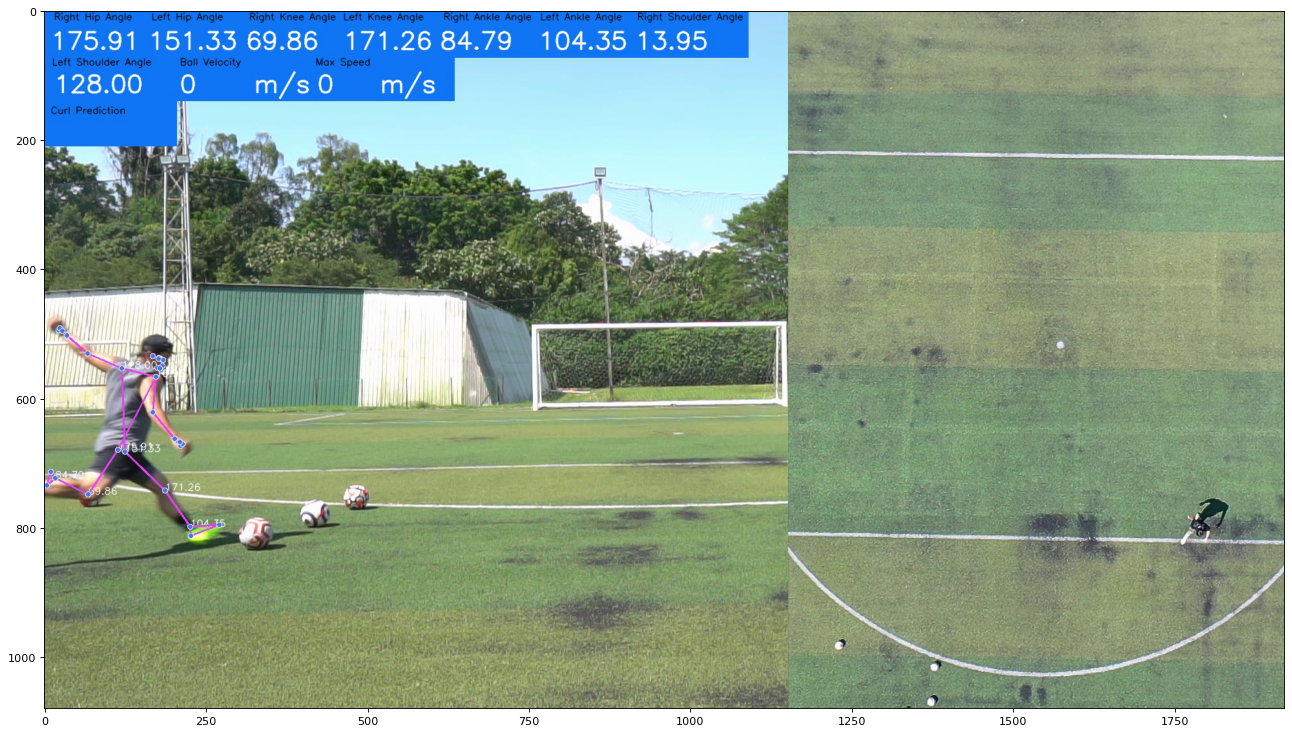

In [10]:
# print saved pose
img = mpimg.imread('../images/angles_charge.jpg')
figure(figsize=(20, 15), dpi=80)
imgplot = plt.imshow(img)
plt.show()

In [11]:
# check that angles were saved
print(anglesDict_freeze)

{'rightankle': ['114.29'], 'leftankle': ['88.27'], 'righthip': ['140.03'], 'lefthip': ['151.11'], 'rightknee': ['158.51'], 'leftknee': ['162.27'], 'rightshoulder': ['20.97'], 'leftshoulder': ['166.84']}


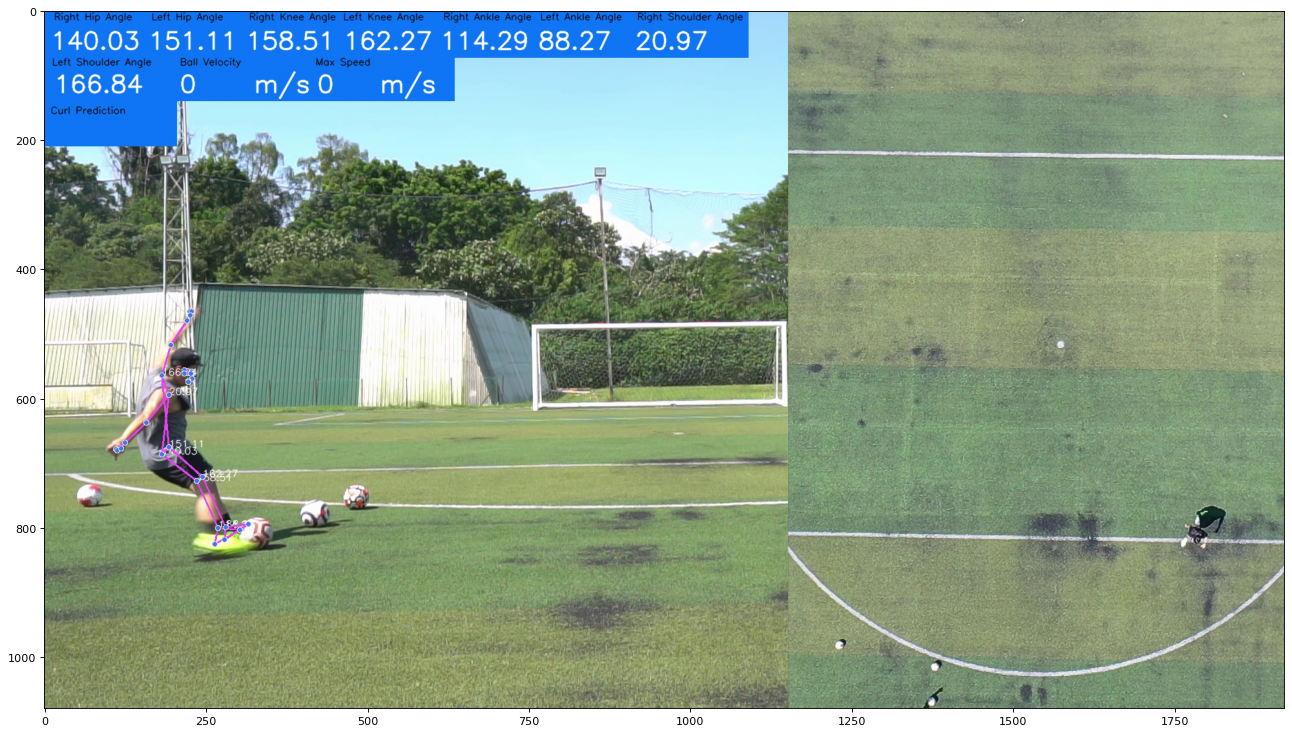

In [12]:
# print saved pose
img = mpimg.imread('../images/angles_release.jpg')
figure(figsize=(20, 15), dpi=80)
imgplot = plt.imshow(img)
plt.show()

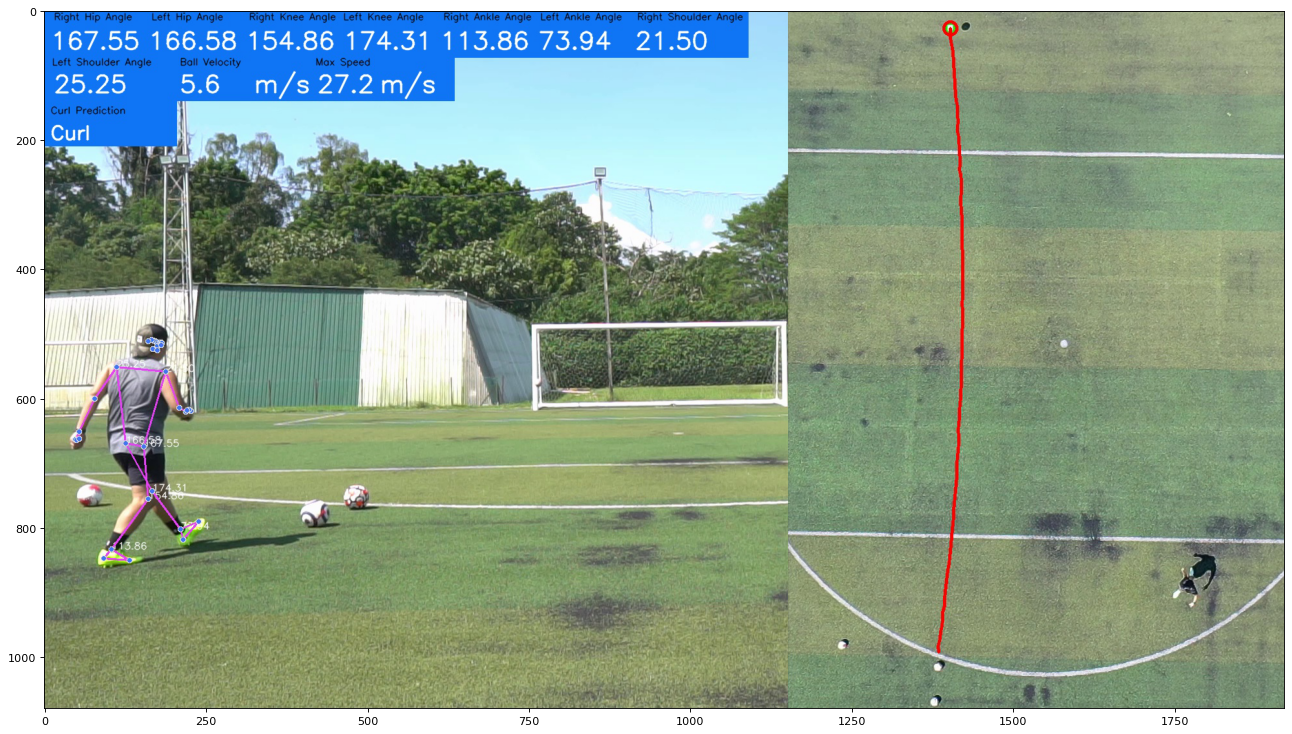

In [13]:
#print flight path
img2 = mpimg.imread('../images/flight_path.jpg')
figure(figsize=(20, 15), dpi=80)
imgplot = plt.imshow(img2)
plt.show()